### Advanced Machine Learning

# Final Assignment  - Detect True vs False Stories (lie detection)

Assignment Start: 11/07/21 00:00<br>
Assignment Due: 18/07/21 23:59 (moodle will be closed for submissions that time)

Jonathan Schler


In [1]:
id="309645737"
name="Yakov Mishayev"

## Introduction
You are provided with a labeled corpus of narratives in Hebrew. The corpus is provided as a csv file. Each row represents a narrative. It has 5 fields: id, author_gender, author_birth_year, narrative and label. The label for each narrative indicates whether this is a true or false story (i.e. the author lied when he told the story) (label "1" for True, and "0" for false). 

You are requested to build a model to predict whether a new story in Hebrew is true or false (i.e a lie). You are provided with 2 files: 
- `train_dataset.csv` - which contains **labeled** examples, and 
- `test_dataset.csv` that contains **unlabled** examples that you'll have to classify and submit the results. The narrtives in this file will have the same fields except of the label field.

(you'll be graded based on the quality of the labels assigned to the `test_dataset.csv`).





## What is expected from you
1. Build a classifier (including all pre-processing steps - as you think may fit (feature engineering, pre-processing, scaling etc) ) that will classify an unlabled document (including reasonable documentation for the steps you chose to do)
2. Report on how you chose to evaluate your algorithm and the scores of that evaluation
3. Apply the model on the unlabeled data set (`test_dataset.csv`), and return the results in the format described below
4. At the end, you are requested to submit 2 files: (a) this notebook, and (b) the output csv file. Submission will be done via moodle. The output csv is the file, that contains the prediction for the `test_dataset.csv`. The naming of the file should be `<your_id_number>.csv` (where `<your_id_number>` will be replaced with you actual ID number). The file will contain for each doc a label `1` (for true narratives) or `0` (for false narratives) (such that each row contains only one label, corresponding to the document in the given row in the `test_dataset.csv` document). You can see a sample output file under the name `123456789.csv` in the moodle.

## Grading Guidelines
1. Overall approach and workable solution (70 pts)
2. Average f1 score of higher than 0.50 (10 pts)
3. Average f1 score of higher than 0.58 (additional 5 pts)
4. Competitive element: 15 Highest average f1 score - will get additional 15 pts, top score the extra 15 points, second highest - extra 14 points etc - in case of similar scores it will be divided proportionaly.

## Other Guidelines
1. Work in indivudual, collaboration is not allowed. 
2. You are allowed to use all the toolsets we learned / mentioned in class, in addition to any other avialble toolsets for text processing or Hebrew data as you think is appropriate.


## Good Luck!

In [2]:
!pip install hebrew_tokenizer

In [3]:
import hebrew_tokenizer as ht
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.compose import ColumnTransformer

C:\Users\Yakov\Desktop\final asigment


C:\Users\Yakov\miniconda3\lib\site-packages\hebrew_tokenizer\__init__.py:9: FutureWarning: Possible nested set at position 20
  from hebrew_tokenizer.api import tokenize


# Part 1 the baseline model

In [4]:
df = pd.read_csv("train_dataset.csv")
df.head()

,Unnamed: 0,author_gender,author_birth_year,narrative,label
0,0,זכר,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1
1,1,זכר,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1
2,2,זכר,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1
3,3,נקבה,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1
4,4,נקבה,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1


In [5]:
#here i change the gender column from string to 0 or 1
df['author_gender'] = [1 if g == 'זכר' else 0 for g in df['author_gender']]
df.head()

,Unnamed: 0,author_gender,author_birth_year,narrative,label
0,0,1,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1
1,1,1,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1
2,2,1,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1
3,3,0,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1
4,4,0,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1


In [6]:
#here i check if the hebrew tokenizer works
hebrew_text = df['narrative'].values
tokens = ht.tokenize(hebrew_text)
for grp, token, token_num, (start_index, end_index) in tokens:
    print('{},{}'.format(grp,token))

ENGLISH,['בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ראשון במדעי המחשב. בשונה מרוב הסטודנטים לא החלטתי ללמוד כדי למצוא עבודה בהמשך אלא כדי להעשיר את עצמי ולהפתח לעולמות חדשים בעולם הטכנולוגיה שכן כשהתחלתי ללמוד כבר עבדתי בענף ההייטק מספר שנים.\nהיום אחרי 3 שנים אני יכול לומר שהמערכת האקדמאית עדיין תקועה מאחור ואיכזבה אותי מאוד. 80% מהתואר בכלל לא נוגע בדברים רלוונטיים לתעשייה וגם ה-20% רחוקים מלהיות חדשניים ומעודכנים.\nהמבנה של הלימודים והמבחנים דחקו אותי למצב שבו למדתי כדי לעבור ולא כדי ללמוד והדגש היה על ציונים במקום על אתגר מחשבתי והעשרת הידע. אני חושב שאם האקדמיה לא תמציא את עצמה מחדש כמו שעשו בחברת Coursera, לא יהיה לה מקום בעולם החדש. דור ה-Z כבר לא יפול למלכודת התואר ולא יסכים לבזבז 3 שנים מחייו רק כדי להוכיח שהוא שווה משרת Junior כלשהי בתחום כלשהו. ספציפית במדעי המחשב אני מסכים שכן חשוב להבין את הצד התיאורתי והמתמטי של הנושא אבל הוא לא יכול להוות 80 אחוז מהתוכן הלימודי. כתיבת הפסקה הזאת היא דוגמא קלאסית לכמה אנחנו מבזבזים את הזמן באקדמיה, משימה שלא קשורה לכלום כאשר יש הבטחה 

Here i build a first baseline model using the CountVectorizer as a back of words tool, 
and logisticRegression as a learning model.

In [7]:
#tokening the words and numbers of the dates and hours 
def tokenize_narrative(t):
    to_ken = []
    for grp, token, token_num, (start_index, end_index) in ht.tokenize(t):
        if grp in ['HEBREW','DATE','HOUR']:
            to_ken.append(token)
    return to_ken

In [8]:
#trying to work with only the narrative column
text_trainval, y = df['narrative'], df['label']
text_train, text_val, y_train, y_val = train_test_split(
    text_trainval, y, stratify=y, random_state=0
)

In [9]:
vect = CountVectorizer(tokenizer=tokenize_narrative)#back of words
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)
feature_names = vect.get_feature_names()

In [10]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)#training the model
print("The model score: {}".format(lr.score(X_val, y_val)))

The model score: 0.46078431372549017


In [11]:
#checking the f1 score
prediction = lr.predict(X_val)
print(classification_report(y_val,prediction))

              precision    recall  f1-score   support

           0       0.46      0.49      0.48        51
           1       0.46      0.43      0.44        51

    accuracy                           0.46       102
   macro avg       0.46      0.46      0.46       102
weighted avg       0.46      0.46      0.46       102



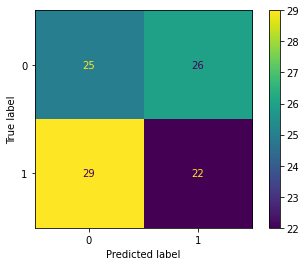

In [12]:
plot_confusion_matrix(lr,X_val,y_val)
plt.show()

 Here in the secend part of the first part i use n-grams,normalization to oprimize the baseline model.

In [13]:
with open('stop_word_list_heb_example.txt', 'r', encoding='utf8') as f:
    stop_words = f.read().split('\n')
from sklearn.preprocessing import normalize
ngrams = [(1,2),(1,3),(1,5),(2,3),(4,4)]
pipes = []
X_trains = []
X_vals = []
for ngram in ngrams:
    pipes.append(make_pipeline(CountVectorizer(ngram_range=ngram,stop_words=stop_words, tokenizer=tokenize_narrative)))
    X_trains.append(normalize(pipes[-1].fit_transform(text_train)))
    X_vals.append(pipes[-1].transform(text_val))

In [14]:
#Function for ploting the features that help the model to optimize the score 
def plot_important_features(coef, feature_names, top_n=20, ax=None,rotation=60):
    """ Function plots the coefficients of respective words in our vocabulary."""
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low,high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n

    ax.bar(myrange, coef[important],color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important],rotation=rotation, ha='right')
    ax.set_xlim(-.7,2*top_n)
    ax.set_frame_on(False)

              precision    recall  f1-score   support

           0       0.57      0.55      0.56        51
           1       0.57      0.59      0.58        51

    accuracy                           0.57       102
   macro avg       0.57      0.57      0.57       102
weighted avg       0.57      0.57      0.57       102



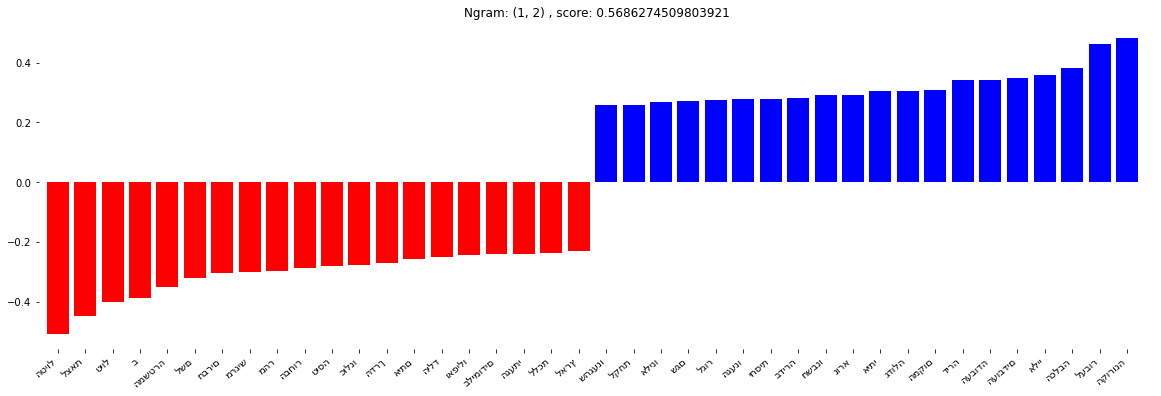

              precision    recall  f1-score   support

           0       0.56      0.55      0.55        51
           1       0.56      0.57      0.56        51

    accuracy                           0.56       102
   macro avg       0.56      0.56      0.56       102
weighted avg       0.56      0.56      0.56       102



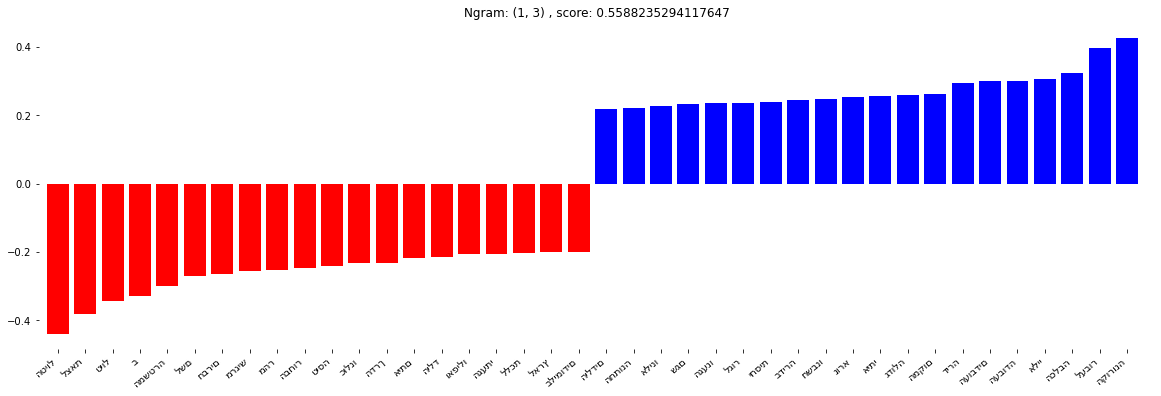

              precision    recall  f1-score   support

           0       0.57      0.51      0.54        51
           1       0.55      0.61      0.58        51

    accuracy                           0.56       102
   macro avg       0.56      0.56      0.56       102
weighted avg       0.56      0.56      0.56       102



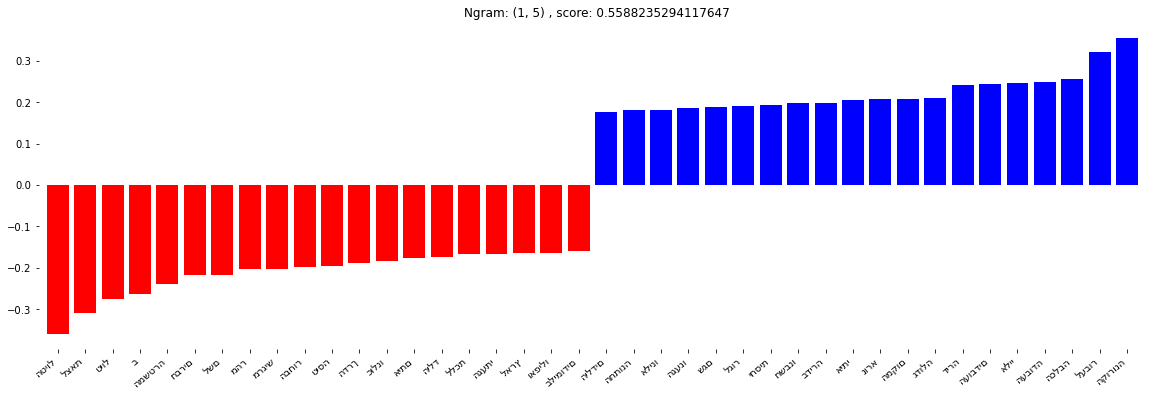

              precision    recall  f1-score   support

           0       0.35      0.33      0.34        51
           1       0.36      0.37      0.37        51

    accuracy                           0.35       102
   macro avg       0.35      0.35      0.35       102
weighted avg       0.35      0.35      0.35       102



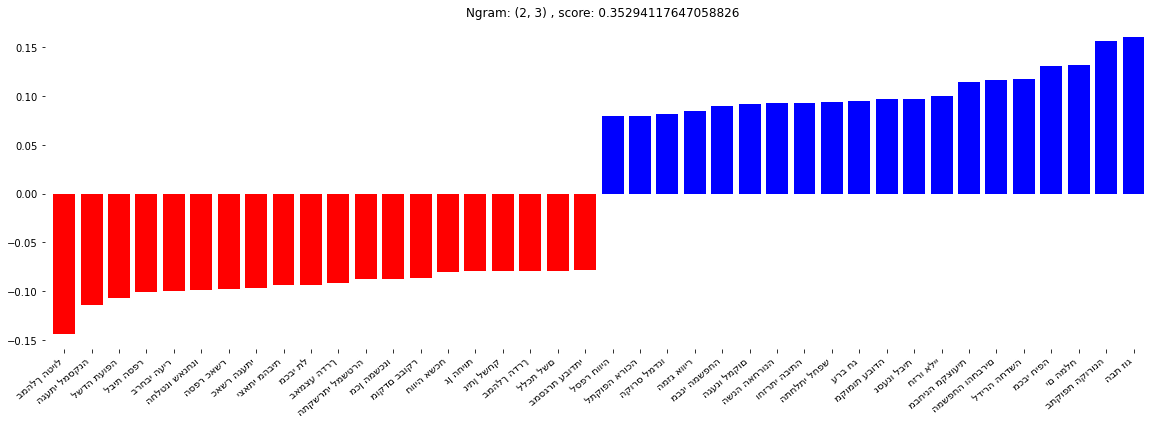

              precision    recall  f1-score   support

           0       0.20      0.02      0.04        51
           1       0.48      0.92      0.64        51

    accuracy                           0.47       102
   macro avg       0.34      0.47      0.34       102
weighted avg       0.34      0.47      0.34       102



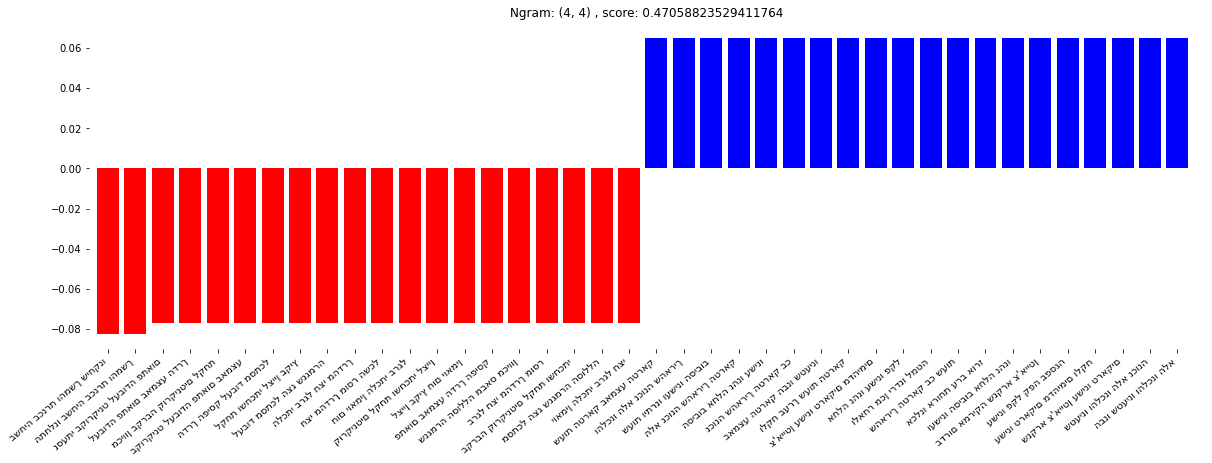

In [15]:
# the plot and the score,we can see here the first two f1 scores are not so bed f1 scores 0.57 and 0.56
for i in range(len(ngrams)):
    feature_names = pipes[i]['countvectorizer'].get_feature_names()
    lr = LogisticRegression().fit(X_trains[i], y_train)
    prediction = lr.predict(X_vals[i])
    print(classification_report(y_val,prediction))
    plt.figure(figsize=(20,6))
    plot_important_features(lr.coef_.ravel(),np.array(feature_names),rotation=40)
    ax = plt.gca()
    plt.title('Ngram: {} , score: {}'.format(ngrams[i],lr.score(X_vals[i],y_val)))
    plt.show()

# Part 2 - here the model i build to work with the test data

Here I build a complex model,with embedding the data , I took the tools and help from this site https://github.com/Ronshm/hebrew-word2vec, here i use a strong learning model-GradientBoostingClassifier, I tried other models like xgboost with feature engineering but I got lower results. 

In [16]:
VB = []
with open('words_list.txt', 'r', encoding='utf8') as f:
    VB = f.read().split('\n')

In [17]:
vectors = np.load('words_vectors.npy')
Embedding = dict(zip(VB,vectors))

In [18]:
#functions fore tokenize and embedding
def token_narrative(t):
    tk = []
    for grp, token, token_num, (start_index, end_index)  in ht.tokenize(t):
        if grp in ['HEBREW','DATE','HOUR']:
            tk.append(token)
    return tk


def vectorize_narrative(k):
    tk = token_narrative(k)
    VA = []
    for w in tk:
        if w in VB:
            VA.append(Embedding[w])
    return np.mean(VA,axis=0)

In [19]:
new_df = df.copy()
new_df['narrative'] = new_df['narrative'].apply(vectorize_narrative)

In [20]:
x = new_df['narrative'].values
M = np.array([VA for VA in x])
Embedding_M = pd.DataFrame(M)
Embedding_M['author_gender'] = new_df['author_gender']
Embedding_M['author_birth_year'] = new_df['author_birth_year']
Embedding_M['n_numbers'] = new_df['author_gender']

In [21]:
#my learning model
from sklearn.ensemble import GradientBoostingClassifier 

y = new_df['label']
train_data, val_data, y_train, y_val = train_test_split(
    Embedding_M, y, stratify=y, random_state=0
)

In [22]:
#using greadsearch for optimization
params = {'learning_rate':[0.1,0.2,0.5,1,1.2]}
clf = GridSearchCV(GradientBoostingClassifier(n_estimators=100,max_depth=1,random_state=0),params)
clf.fit(train_data,y_train)

GridSearchCV(estimator=GradientBoostingClassifier(max_depth=1, random_state=0),
             param_grid={'learning_rate': [0.1, 0.2, 0.5, 1, 1.2]})

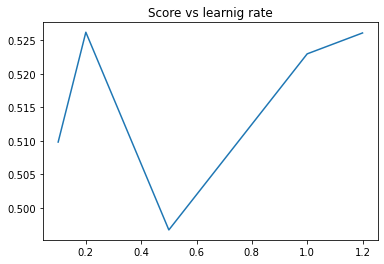

In [23]:
scores = clf.cv_results_['mean_test_score']
plt.title('Score vs learnig rate')
plt.plot([0.1,0.2,0.5,1,1.2],scores)
plt.show()

In [24]:
print(classification_report(y_val,clf.predict(val_data)))

              precision    recall  f1-score   support

           0       0.57      0.63      0.60        51
           1       0.59      0.53      0.56        51

    accuracy                           0.58       102
   macro avg       0.58      0.58      0.58       102
weighted avg       0.58      0.58      0.58       102



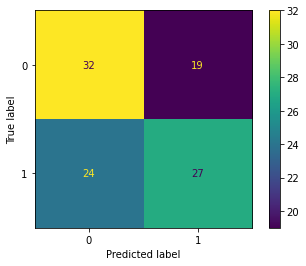

In [25]:
plot_confusion_matrix(clf.best_estimator_,val_data,y_val)
plt.show()

# part 3 - testing the model on test data

the model traine below, here i testing the model and do the same pre-processing

In [50]:
df = pd.read_csv("test_dataset.csv", index_col=0)
df.head()

,author_gender,author_birth_year,narrative
0,זכר,2002,זה התחיל בשעת השקיעה.הגענו לחוף מדרום לעין גדי...
1,נקבה,1995,"כזוג מאורס טרי סגרנו תאריך, אולם אירועים, ספקי..."
2,זכר,1995,"הגעתי לשירות המדינה אחרי שנתיים כפעיל בתנועת ""..."
3,זכר,1991,"בשנה האחרונה ,\nפרצה מחלת הקורונה דבר שאף אחד ..."
4,זכר,1995,"החוויה שלי מתחילה במכון הטכנולוגי חולון, אשר ש..."


In [51]:
#here i change again the gender column from string to 0 or 1
df['author_gender'] = [1 if g == 'זכר' else 0 for g in df['author_gender']]
df.head()

,author_gender,author_birth_year,narrative
0,1,2002,זה התחיל בשעת השקיעה.הגענו לחוף מדרום לעין גדי...
1,0,1995,"כזוג מאורס טרי סגרנו תאריך, אולם אירועים, ספקי..."
2,1,1995,"הגעתי לשירות המדינה אחרי שנתיים כפעיל בתנועת ""..."
3,1,1991,"בשנה האחרונה ,\nפרצה מחלת הקורונה דבר שאף אחד ..."
4,1,1995,"החוויה שלי מתחילה במכון הטכנולוגי חולון, אשר ש..."


the same pre-processing

In [52]:
VB = []
with open('words_list.txt', 'r', encoding='utf8') as f:
    VB = f.read().split('\n')
vectors = np.load('words_vectors.npy')
Embedding = dict(zip(VB,vectors))    

In [53]:
vectors = np.load('words_vectors.npy')
Embedding = dict(zip(VB,vectors))

In [54]:
def token_narrative(t):
    tk = []
    for grp, token, token_num, (start_index, end_index)  in ht.tokenize(t):
        if grp in ['HEBREW','DATE','HOUR']:
            tk.append(token)
    return tk


def vectorize_narrative(k):
    tk = token_narrative(k)
    VA = []
    for w in tk:
        if w in VB:
            VA.append(Embedding[w])
    return np.mean(VA,axis=0)

In [59]:
new_df = df['narrative'].apply(vectorize_narrative).to_numpy()

In [63]:
new_df = pd.DataFrame(np.array(new_df.tolist()))

In [65]:
new_df['author_gender'] = df['author_gender']
new_df['author_birth_year'] = df['author_birth_year']
new_df['n_numbers'] = df['author_gender']

In [68]:
pred = pd.DataFrame(clf.predict(new_df), columns=['label'])
pred.head(3)

,label
0,0
1,1
2,1


In [69]:
pred.to_csv('309645737.csv', index=False)